<a href="https://colab.research.google.com/github/fsminako/text_rag/blob/main/5588654_rag_m3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RETRIEVAL AUGMENTED GENERATION (RAG) FOR MEDICAL RESEARCH

## Dataset Loading

The dataset used in this study will be medical research abstract sourced from the Arxiv library.

In [1]:
#Installing necessary packages
!pip install arxiv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=83969c2119535d99c6b5ba40028cacf0bc1fabcb1d1c63af874a11fff5c575fe
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


In [2]:
#Import packages
import arxiv
import numpy as np
import pandas as pd

In [3]:
#Total observation that will be used in this study is 10,000 abstracts
n_records = 50

client = arxiv.Client()

search = arxiv.Search(
  query = "medical", #specifying the topic of the research
  max_results = n_records,
  sort_by = arxiv.SortCriterion.SubmittedDate #sorting the search based on the latest journal
)

results = client.results(search)

In [4]:
#Abstract extraction process
abstracts = []

for r in client.results(search):
  abstracts.append(r.summary)

# Naming the column for the dataframe
df_data = {'abstract': abstracts}


In [5]:
#Saving the extracted data as a data frame
df = pd.DataFrame(df_data)
df.head()

,abstract
0,While deep networks have achieved broad succes...
1,Denoising diffusion probabilistic models (DDPM...
2,Model observers are computational tools to eva...
3,Modern AI models provide the key to a long-sta...
4,In the expanding field of language model appli...


## Data Cleaning

In [6]:
import re

In [7]:
def cleaning(text):
    if isinstance(text, str):
        url_pattern = re.compile(r'https://\S+|www\.\S+')
        text = url_pattern.sub('', text)
        text = re.sub(r"[’]", "'", text)
        text = re.sub(r"[^a-zA-Z\s'-.]", "", text)
        text = ' '.join(text.split())
        text = text.lower()
    return text

df['abstract'] = df['abstract'].apply(lambda x: cleaning(x))

This process will:
*   remove url from the texts
*   converting " ’ " to " ' "
*   remove non-alphabetic character except ' and -
*   remove any extra whitespace (ensure that only single whitespace between each word)
*   convert all character into lowercase

In [8]:
df.head()

,abstract
0,while deep networks have achieved broad succes...
1,denoising diffusion probabilistic models (ddpm...
2,model observers are computational tools to eva...
3,modern ai models provide the key to a long-sta...
4,in the expanding field of language model appli...


In [9]:
df['abstract'] = df['abstract'].astype(str)

merged_abstract = df['abstract'].str.cat(sep=' ')

df = pd.DataFrame({'abstract': [merged_abstract]})

#Save the dataframe as a txt file
df.to_csv("abstract.txt", sep=' ', index=False, header = False)

## Chunking

In [10]:
#Installing required library
!pip install llama_index.core
!pip install llama_index.readers.file
!pip install pysbd
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia

In [11]:
#Importing the library
from llama_index.readers.file import FlatReader
from llama_index.core.node_parser import SentenceSplitter
import pysbd

To separate the text into chunks, we will be using the SentenceSplitter from llama_index. This function will split the text in such a way that one sentence will not be separated into different chunk

In [12]:
with open("/content/abstract.txt") as f:
    documents = f.readlines()
    f.close()

seg = pysbd.Segmenter(language="en", clean=False)
sentences = seg.segment(documents[0])

print('Loaded Text String')

Loaded Text String


In [13]:
# Get the length of each sentence
sentence_length = [len(each) for each in sentences]
# Determine longest outlier
long = np.mean(sentence_length) + np.std(sentence_length) *2
# Determine shortest outlier
short = np.mean(sentence_length) - np.std(sentence_length) *2

# Shorten long sentences
text = ''
for each in sentences:
    if len(each) > long:
        # let's replace all the commas with dots
        comma_splitted = each.replace(',', '.')
    else:
        text+= f'{each}. '
sentences = text.split('. ')
# Now let's concatenate short ones
text = ''
for each in sentences:
    if len(each) < short:
        text+= f'{each} '
    else:
        text+= f'{each}. '

In [14]:
print(text)

"while deep networks have achieved broad success in analyzing natural images, when applied to medical scans, they often fail in unexcepted situations.  we investigate this challenge and focus on model sensitivity to domain shifts, such as data sampled from different hospitals or data confounded by demographic variables such as sex, race, etc, in the context of chest x-rays and skin lesion images.  a key finding we show empirically is that existing visual backbones lack an appropriate prior from the architecture for reliable generalization in these settings.  taking inspiration from medical training, we propose giving deep networks a prior grounded in explicit medical knowledge communicated in natural language.  to this end, we introduce knowledge-enhanced bottlenecks (knobo), a class of concept bottleneck models that incorporates knowledge priors that constrain it to reason with clinically relevant factors found in medical textbooks or pubmed.  knobo uses retrieval-augmented language m

Before chunking the data into paragrah based on their semantic similarity, we will embed the sentences first to be able to calculate their cosine similarity

In [15]:
from sentence_transformers import SentenceTransformer

embedding_chunk = SentenceTransformer("neuml/pubmedbert-base-embeddings")

# Split text into sentences
sentences = text.split('. ')
# Embed sentences
embeddings = embedding_chunk.encode(sentences)
print(embeddings.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/6.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/667 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/706k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(444, 768)


In [16]:
# Normalise the embeddings
normalise = np.linalg.norm(embeddings, axis=1, keepdims=True)
embeddings = embeddings / normalise

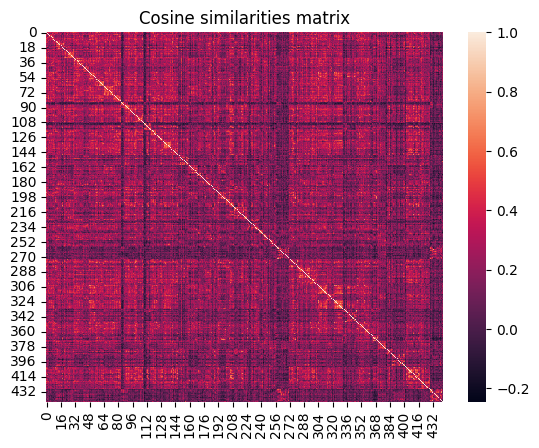

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Create similarities matrix
similarities = cosine_similarity(embeddings)
# Lets plot the result we got
sns.heatmap(similarities).set_title('Cosine similarities matrix');

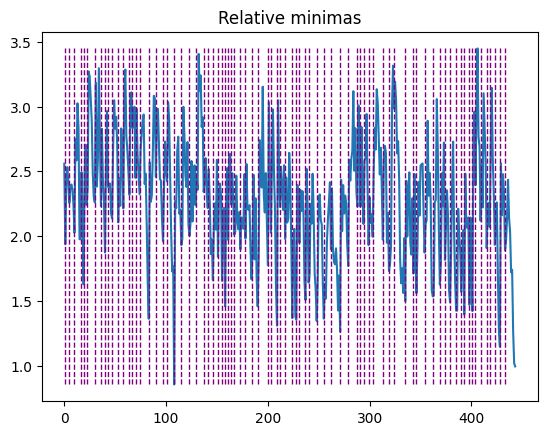

In [18]:
from scipy.signal import argrelextrema
import math
import matplotlib.pyplot as plt

def rev_sigmoid(x:float)->float:
    return (1 / (1 + math.exp(0.5*x)))

def activate_similarities(similarities:np.array, p_size=10)->np.array:
        """ Function returns list of weighted sums of activated sentence similarities
        Args:
            similarities (numpy array): it should square matrix where each sentence corresponds to another with cosine similarity
            p_size (int): number of sentences are used to calculate weighted sum
        Returns:
            list: list of weighted sums
        """
        # To create weights for sigmoid function we first have to create space. P_size will determine number of sentences used and the size of weights vector.
        x = np.linspace(-10,10,p_size)
        # Then we need to apply activation function to the created space
        y = np.vectorize(rev_sigmoid)
        # Because we only apply activation to p_size number of sentences we have to add zeros to neglect the effect of every additional sentence and to match the length ofvector we will multiply
        activation_weights = np.pad(y(x),(0,similarities.shape[0]-p_size))
        ### 1. Take each diagonal to the right of the main diagonal
        diagonals = [similarities.diagonal(each) for each in range(0,similarities.shape[0])]
        ### 2. Pad each diagonal by zeros at the end. Because each diagonal is different length we should pad it with zeros at the end
        diagonals = [np.pad(each, (0,similarities.shape[0]-len(each))) for each in diagonals]
        ### 3. Stack those diagonals into new matrix
        diagonals = np.stack(diagonals)
        ### 4. Apply activation weights to each row. Multiply similarities with our activation.
        diagonals = diagonals * activation_weights.reshape(-1,1)
        ### 5. Calculate the weighted sum of activated similarities
        activated_similarities = np.sum(diagonals, axis=0)
        return activated_similarities

# Let's apply our function. For long sentences i reccomend to use 10 or more sentences
activated_similarities = activate_similarities(similarities, p_size=10)

# Let's create empty fig for our plor
fig, ax = plt.subplots()
### 6. Find relative minima of our vector. For all local minimas and save them to variable with argrelextrema function
minmimas = argrelextrema(activated_similarities, np.less, order=2) #order parameter controls how frequent should be splits. I would not reccomend changing this parameter.
# plot the flow of our text with activated similarities
sns.lineplot(y=activated_similarities, x=range(len(activated_similarities)), ax=ax).set_title('Relative minimas');
# Now lets plot vertical lines in order to see where we created the split
plt.vlines(x=minmimas, ymin=min(activated_similarities), ymax=max(activated_similarities), colors='purple', ls='--', lw=1, label='vline_multiple - full height')

(0.0, 100.0)

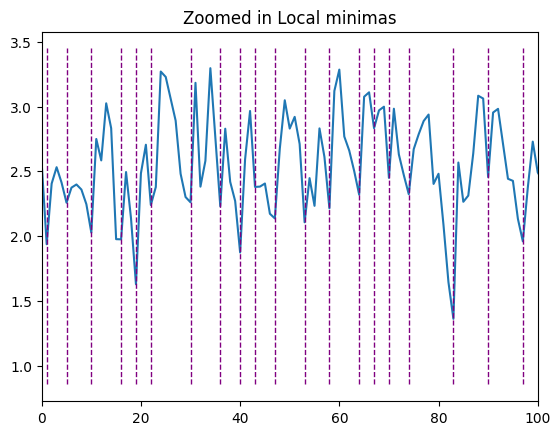

In [19]:
fig, ax = plt.subplots()
# for all local minimals
sns.lineplot(y=activated_similarities, x=range(len(activated_similarities)), ax=ax).set_title('Zoomed in Local minimas');
# Now lets plot vertical line in order to understand if we have done what we wanted
plt.vlines(x=minmimas, ymin=min(activated_similarities), ymax=max(activated_similarities), colors='purple', ls='--', lw=1, label='vline_multiple - full height')
ax.set_xlim([0,100])

In [20]:
!mkdir -p '/content/chunk_data/'

In [21]:
import os

split_points = [each for each in minmimas[0]]
text = ''
paragraphs = []
for num, each in enumerate(sentences):
    if num in split_points:
        if text:
            paragraphs.append(text.strip())
        text = f'{each}. '
    else:
        text += f'{each}. '
if text:
    paragraphs.append(text.strip())

output_dir = '/content/chunk_data/'

# Save each paragraph to a separate text file
for i, paragraph in enumerate(paragraphs):
    file_path = os.path.join(output_dir, f'chunk_{i+1}.txt')
    with open(file_path, 'w') as file:
        file.write(paragraph)

## Embedding

In [22]:
#Installing necessary packages
!pip install langchain
!pip install langchain-community
!pip install sentence-transformers
!pip install llama-index-embeddings-langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.5/308.5 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.8/122.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 20.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.2 MB/s eta 0:00:00


For our medical abstracts dataset, we will use PubMedBERT as our embedding model. PubMedBERT is trained on abstracts extracted from PubMed making it highly suitable for our dataset

In [23]:
#Importing necessary library for the embeddings model
from langchain.embeddings import HuggingFaceEmbeddings

#Importing PubMedBERT from the hugging face library
embedding_model = HuggingFaceEmbeddings(model_name="microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

In [24]:
#Configurating the default embedding model into our chosen embedding model
from llama_index.core import Settings
Settings.embed_model = embedding_model

## Indexing

In [25]:
from llama_index.core import SimpleDirectoryReader

# Load all the documents in the chunk_data directory
reader = SimpleDirectoryReader("/content/chunk_data") # load documents from the /data folder
documents = reader.load_data()
print(f"{len(documents)} documents are loaded")

82 documents are loaded


In [26]:
#Installing necessary library
!pip install llama-index-vector-stores-chroma
!pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 8.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26

In [27]:
#Importing required packafes
from llama_index.vector_stores.chroma import ChromaVectorStore
import chromadb
from llama_index.core import StorageContext
from llama_index.core import VectorStoreIndex

# Creating a medical_articles database
db = chromadb.PersistentClient(path="./medical_articles_db")

# Create a table inside the database called "medical-abstract"
chroma_collection = db.create_collection("medical-abstract")

vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# Indexing the documents into the databse
vector_index = VectorStoreIndex.from_documents(
    documents,
    storage_context = storage_context,
    embed_model = embedding_model
)

# Printing the metadata
print(chroma_collection)

name='medical-abstract' id=UUID('db4cc721-bd7b-458f-8b3e-12f05138c9da') metadata=None tenant='default_tenant' database='default_database'


## Prompt Template

Prompt template is crucial to engineer better response. We will use a customised prompt template from the llama library.
The prompt template that we use ensure that the LLM generate response as a medical expert but avoiding the use of medical terminology that is not generally used.

In [37]:
from llama_index.core.llms import ChatMessage, MessageRole
from llama_index.core import ChatPromptTemplate

#Prompt string for the LLM
qa_prompt_str = (
    "You are a medical expert, give responses to the following "
    "question: {query_str}. Do not use technical words, give easy "
    "to understand responses."
)

# Text QA Prompt
chat_text_qa_msgs = [
    ChatMessage(
        role=MessageRole.SYSTEM,
        content=(
            "Always answer the question, even if the context isn't helpful."
        ),
    ),
    ChatMessage(role=MessageRole.USER, content=qa_prompt_str),
]

text_qa_template = ChatPromptTemplate(chat_text_qa_msgs)

## Query Processing and Response Generation

We will inegrate our RAG system with T5 as the LLM. T5 utilises text-to-text approach where all NLP problems are converted into a text generation format, makes it particularly adaptable for specialized domains, including the medical field.

In [29]:
#Installing necessary packages
!pip install transformers
!pip install llama-index-llms-langchain
!pip install llama-index-llms-ollama

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.2.1
    Uninstalling langchain-core-0.2.1:
      Successfully uninstalled langchain-core-0.2.1
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.2.0
    Uninstalling langchain-text-splitters-0.2.0:
      Successfully uninstalled langchain-text-splitters-0.2.0
  Attempting uninstall: langchain-community
    Found existing installation: langchain-community 0.2.1
    Uninstalling langchain-community-0.2.1:
      Successfully uninstalled langchain-community-0.2.1
  Attempting uninstall: langchain
    Found existing installation: langchain 0.2.1
    Uninstalling langchain-0.2.1:
      Successfully uninstalled

In [30]:
!curl https://ollama.ai/install.sh | sed 's#https://ollama.ai/download#https://github.com/jmorganca/ollama/releases/download/v0.1.30#' | sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0>>> Downloading ollama...
100 10091    0 10091    0     0  40802      0 --:--:-- --:--:-- --:--:-- 40854
############################################################################################# 100.0%
>>> Installing ollama to /usr/local/bin...
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [31]:
#Importing LLM from Hugging face
OLLAMA_MODEL='phi:latest'

os.environ['OLLAMA_MODEL'] = OLLAMA_MODEL
!echo $OLLAMA_MODEL

from llama_index.llms.ollama import Ollama
llm = Ollama(model=OLLAMA_MODEL, request_timeout=240.0)

phi:latest


In [32]:
import subprocess

command = "nohup ollama serve&"

process = subprocess.Popen(command,
                            shell=True,
                            stdout=subprocess.PIPE,
                            stderr=subprocess.PIPE)

In [33]:
#Testing the LLM without integrating with our vector database
!ollama run $OLLAMA_MODEL "What is the application of large language models in healthcare"

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠋ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠸ pulling manifest ⠸ pulling manifest ⠴ pulling manifest 
pulling 04778965089b...   0% ▕▏    0 B/1.6 GB                  pulling manifest 
pulling 04778965089b...   0% ▕▏    0 B/1.6 GB                  pulling manifest 
pulling 04778965089b...   0% ▕▏    0 B/1.6 GB                  pulling manifest 
pulling 04778965089b...   0% ▕▏    0 B/1.6 GB                  pulling manifest 
pulling 04778965089b...   0% ▕▏    0 B/1.6 GB                  pulling manifest 
pulling 04778965089b...   0% ▕▏    0 B/1.6 GB                  pulling manifest 
pulling 04778965089b...   0% ▕▏    0 B/1.6 GB                  pulling manifest 
pulling 04778965089b...   0% ▕▏    0 B/1.6 GB                  pulling manifest 
pulling 04778965089b...   0% ▕▏ 7.4 MB/1.6 GB    

In [34]:
#Settings Ollama as the default LLM
Settings.llm = llm

In [35]:
#Input query for our RAG system
query = "What is the application of large language models in healthcare"

In [38]:
#Response processing
query_engine = vector_index.as_query_engine(
   text_qa_template=text_qa_template,
   llm=llm
)

response = query_engine.query(query)
response.response

KeyboardInterrupt: 

In [ ]:
#Retrieving the related documents to generate the response
response.metadata

{'7090c64e-2b43-4c44-849c-3fcbcca95736': {'file_path': '/content/chunk_data/chunk_14.txt',
  'file_name': 'chunk_14.txt',
  'file_type': 'text/plain',
  'file_size': 571,
  'creation_date': '2024-05-26',
  'last_modified_date': '2024-05-26'},
 'f631f2b0-74f4-4159-bd0f-0f5ff8e4b6da': {'file_path': '/content/chunk_data/chunk_11.txt',
  'file_name': 'chunk_11.txt',
  'file_type': 'text/plain',
  'file_size': 717,
  'creation_date': '2024-05-26',
  'last_modified_date': '2024-05-26'}}

In [ ]:
paragraphs[13]

'our experiments show that d saliency methods do not provide explanations of sufficient quality, and that there is margin for future improvements and safer applications of d cnns in critical fields.  transformers have significantly advanced the modeling of electronic health records (ehr), yet their deployment in real-world healthcare is limited by several key challenges.  firstly, the quadratic computational cost and insufficient context length of these models pose significant obstacles for hospitals in processing the extensive medical histories typical in ehr data.'

In [ ]:
paragraphs[10]

'of the baseline  these require no additional work by the user.  in the expanding field of language model applications, medical knowledge representation remains a significant challenge due to the specialized nature of the domain.  large language models, such as gpt-, obtain reasonable scores on medical question answering tasks, but smaller models are far behind.  in this work, we introduce a method to improve the proficiency of a small language model in the medical domain by employing a two-fold approach.  we first fine-tune the model on a corpus of medical textbooks.  then, we use gpt- to generate questions similar to the downstream task, prompted with textbook knowledge, and use them to fine-tune the model.'